**Note**: Skip this notebook if you don't want to explore other complex CNN models (ResNet, NaimishNet, etc.).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

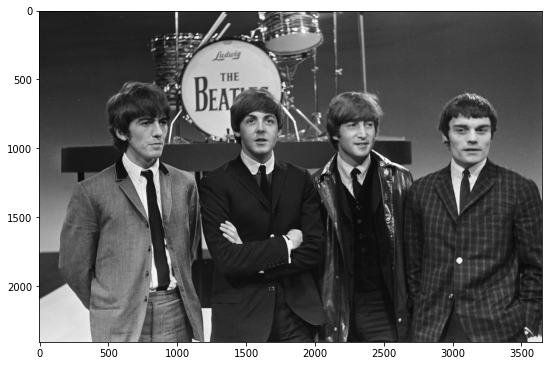

In [2]:
import cv2

# load in color image for face detection
image_1 = cv2.imread("images/obamas.jpg")
image_2 = cv2.imread("images/mona_lisa.jpg")
image_3 = cv2.imread("images/the_beatles.jpg")

# switch red and blue color channels
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

images = [image_1, image_2, image_3]

# plot the image
fig = plt.figure(figsize=(9, 9))
plt.imshow(images[2])

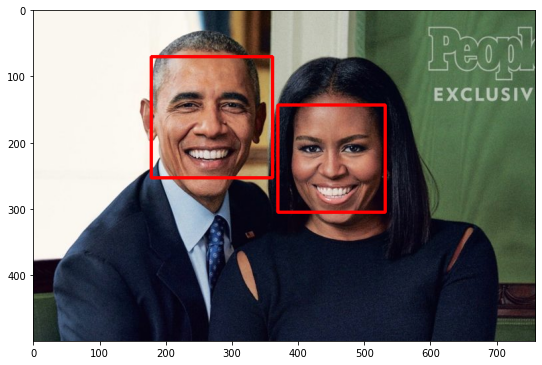

In [3]:
face_cascade = cv2.CascadeClassifier(
    "detector_architectures/haarcascade_frontalface_default.xml"
)


faces_list = []
images_with_detections = []
for image in images:
    faces_list.append(face_cascade.detectMultiScale(image, 1.3, 5))
    images_with_detections.append(image.copy())

for i, faces in enumerate(faces_list):
    rec_thickness = images_with_detections[i].shape[0] // 150
    for (x, y, w, h) in faces:
        cv2.rectangle(
            images_with_detections[i],
            (x, y),
            (x + w, y + h),
            (255, 0, 0),
            rec_thickness,
        )

fig = plt.figure(figsize=(9, 9))

plt.imshow(images_with_detections[0])

In [4]:
import torch
from models import NaimishNet, Resnet18Grayscale

img_size = 224

# net = NaimishNet(image_size=img_size, kernels=[5, 5, 5, 5], use_maxp=False)
resnet18 = Resnet18Grayscale()

model_dir = "models/"
model_name = "resnet18_gray_epochs2_bs64_vloss0.01871.pt"

resnet18.load_state_dict(torch.load(model_dir + model_name))

resnet18.eval()

Resnet18Grayscale(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [5]:
img_size = 224

naimishnet = NaimishNet(image_size=img_size, kernels=[5, 5, 5, 5], use_maxp=False)

model_name = "bs64_img_s224_k[5, 5, 5, 5]_out_ch[32, 64, 128, 256]_dp[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]_maxpFalse_ep2_vloss0.15174.pt"

naimishnet.load_state_dict(torch.load(model_dir + model_name))

naimishnet.eval()

NaimishNet(
  (conv1): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu1): ReLU()
  )
  (maxp1): Sequential(
    (maxp1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (dropout1): Dropout(p=0, inplace=False)
    (bachnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu2): ReLU()
  )
  (maxp2): Sequential(
    (maxp2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (dropout2): Dropout(p=0, inplace=False)
    (bachnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu3): ReLU()
  )
  (maxp3): Sequential(
    (maxp3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (dropout3): Dropout(p=0, inplace=False)
    (bachnorm3): BatchNorm2d(1

In [6]:
def detect_keypoints(image_nr, scale, net):
    fig = plt.figure(figsize=(10, 10))
    i = 0
    image_copy = np.copy(images[image_nr])
    for (x, y, w, h) in faces_list[image_nr]:

        # Select the region of interest that is the face in the image
        roi = image_copy[y - scale : y + h + scale, x - scale : x + w + scale]

        # Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        # Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi / 255.0
        h, w = roi.shape

        roi = cv2.resize(roi, (img_size, img_size))

        # Make copy for displaying keypoint over
        roi_copy = np.copy(roi)

        # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)

        # if image has no grayscale color channel, add one
        if len(roi.shape) == 2:
            # add that third color dim
            roi = roi.reshape(roi.shape[0], roi.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        roi = roi.transpose((2, 0, 1))

        roi = torch.from_numpy(roi)
        roi = roi.type(torch.FloatTensor)

        roi.unsqueeze_(0)

        # forward pass to get net output
        output_pts = net(roi)
        # reshape to size x 68 x 2 pts
        output_pts = output_pts.view(68, -1)

        # undo normalization of keypoints
        output_pts = output_pts.detach().numpy()
        output_pts = output_pts * (roi_copy.shape[0] / 4) + roi_copy.shape[0] / 2

        # Display each detected face and the corresponding keypoints
        fig.add_subplot(2, 2, i + 1)
        plt.imshow(roi_copy, cmap="gray")
        plt.scatter(output_pts[:, 0], output_pts[:, 1], s=5, marker=".", c="m")
        plt.axis("off")
        i += 1

    plt.show()

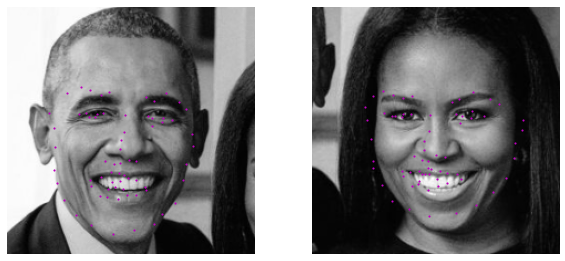

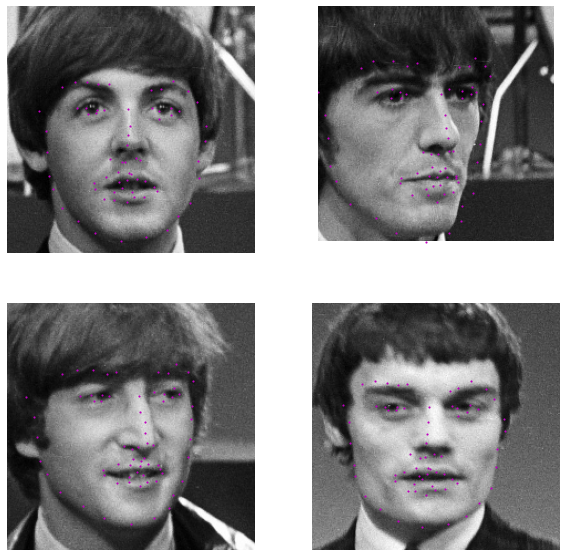

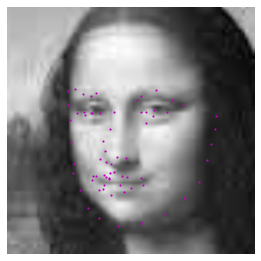

In [7]:
detect_keypoints(0, 40, resnet18)
detect_keypoints(2, 50, resnet18)
detect_keypoints(1, 10, resnet18)

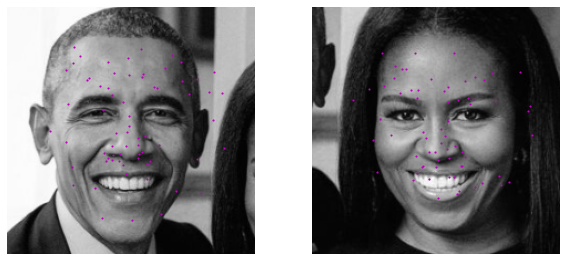

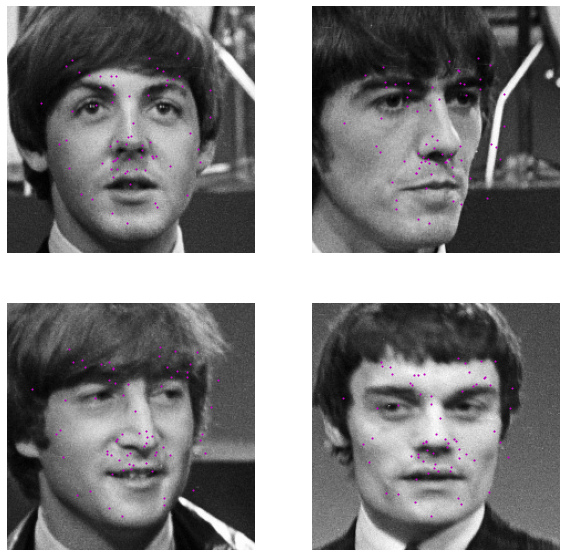

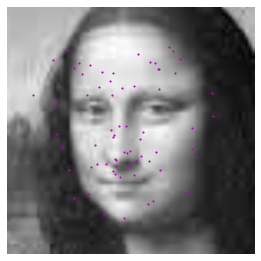

In [8]:
detect_keypoints(0, 40, naimishnet)
detect_keypoints(2, 50, naimishnet)
detect_keypoints(1, 10, naimishnet)